# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  | [Comparativa de infectados](#Comunidades_Casos)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  |  [Comparativa de infectados, hoy](#Comunidades_Casos_Hoy)| [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |   [Comparativa de curados](#Curados)| [Hospitalizados hoy, en Madrid](#Reporte_Hospitalizados_Madrid)| [Predicción de hospitalizados hoy, en Madrid](#Prediccion_Hospitalizados_Madrid)|
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-04-23,Madrid,60487,1288,86,0.021294,7684,107,-10,0.013925,0.127036,33645,613.0,26842,0.475932,981,7077
2020-04-22,Madrid,59199,1202,168,0.020304,7577,117,8,0.015441,0.127992,33032,755.0,26167,0.628120,1024,7464
2020-04-21,Madrid,57997,1034,-1045,0.017829,7460,109,-3,0.014611,0.128627,32277,515.0,25720,0.498066,1076,7930
2020-04-20,Madrid,56963,2079,141,0.036497,7351,112,5,0.015236,0.129049,31762,449.0,25201,0.215969,1111,8191
2020-04-19,Madrid,54884,1938,985,0.035311,7239,107,-18,0.014781,0.131896,31313,838.0,23571,0.432405,1123,8291
2020-04-18,Madrid,52946,953,-346,0.017999,7132,125,-5,0.017527,0.134703,30475,1039.0,22471,1.090241,1094,8597
2020-04-17,Madrid,51993,1299,131,0.024984,7007,130,-23,0.018553,0.134768,29436,945.0,22557,0.727483,1154,9141
2020-04-16,Madrid,50694,1168,-310,0.023040,6877,153,-3,0.022248,0.135657,28491,1058.0,22203,0.905822,1206,9653
2020-04-15,Madrid,49526,1478,576,0.029843,6724,156,11,0.023200,0.135767,27433,1186.0,22093,0.802436,1244,10116


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


In [4]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

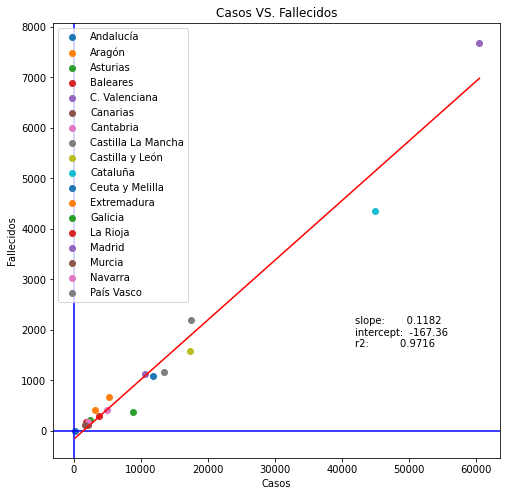

Total: Casos 213024
Total: Fallecidos 22157


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,224,6
Murcia,1721,124
Baleares,1861,168
Canarias,2113,121
Cantabria,2206,173
Asturias,2453,223
Extremadura,3260,407
La Rioja,3839,303
Navarra,4994,409


In [5]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


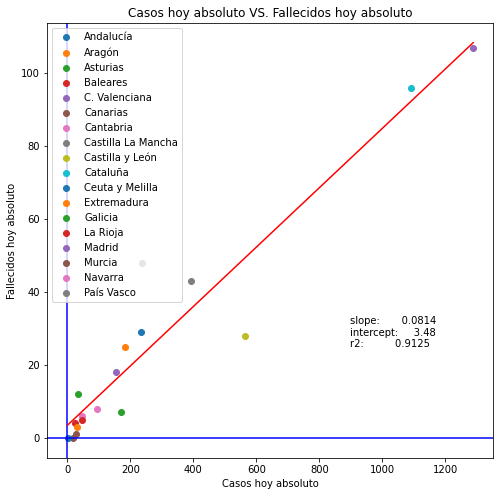

Total: Casos hoy absoluto 4635
Total: Fallecidos hoy absoluto 440


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Ceuta y Melilla,1,0
Canarias,19,0
Baleares,25,4
Murcia,26,1
Extremadura,30,3
Asturias,34,12
Cantabria,46,6
La Rioja,47,5
Navarra,95,8


In [6]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

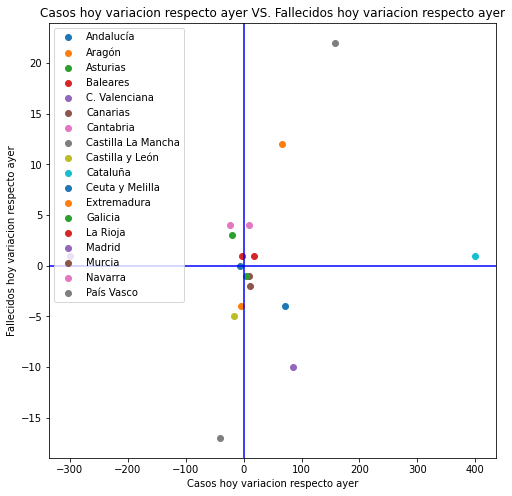

Total: Casos hoy variacion respecto ayer 424
Total: Fallecidos hoy variacion respecto ayer 5


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
C. Valenciana,-300,1
Castilla La Mancha,-40,-17
Navarra,-23,4
Asturias,-20,3
Castilla y León,-17,-5
Ceuta y Melilla,-6,0
Extremadura,-4,-4
Baleares,-3,1
Galicia,5,-1


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [8]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [9]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

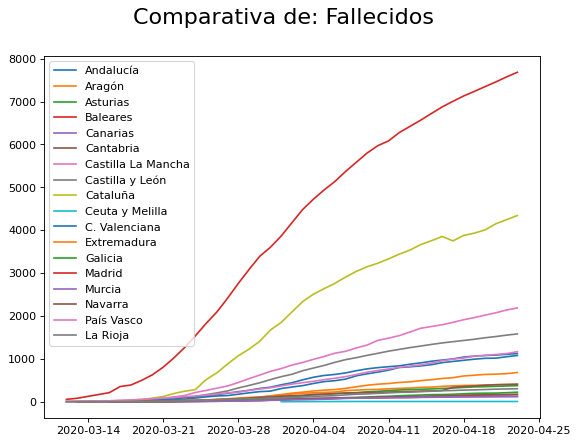

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


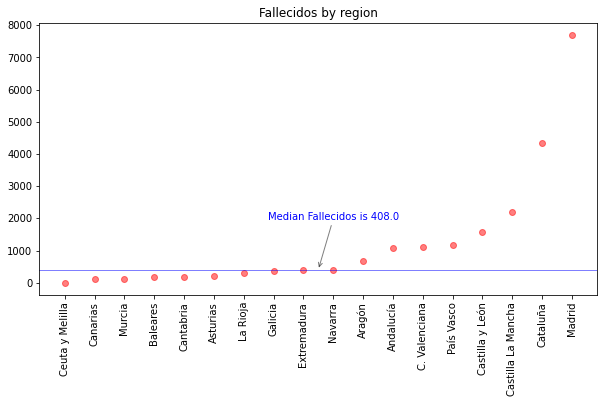

In [10]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

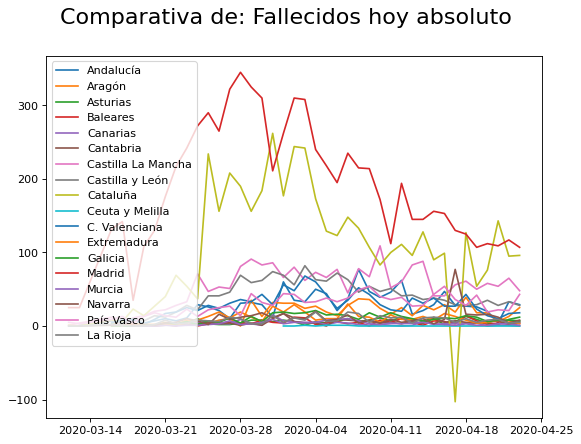

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


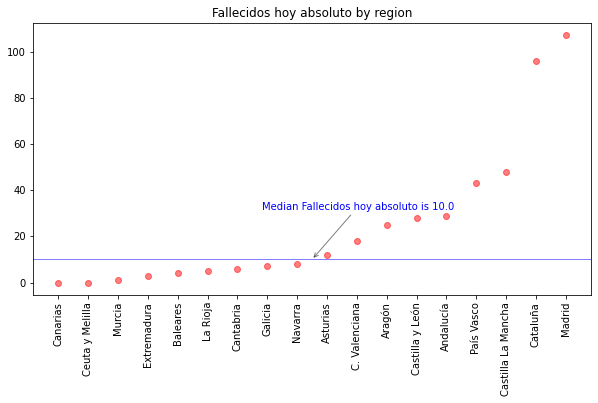

In [11]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

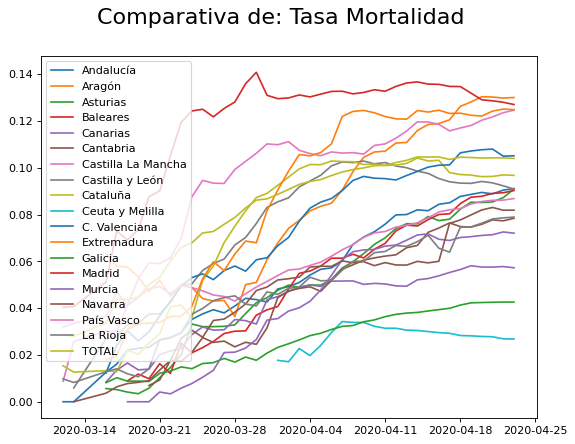

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


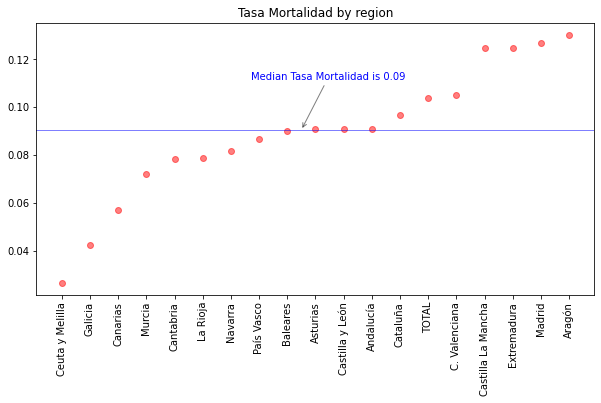

In [12]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

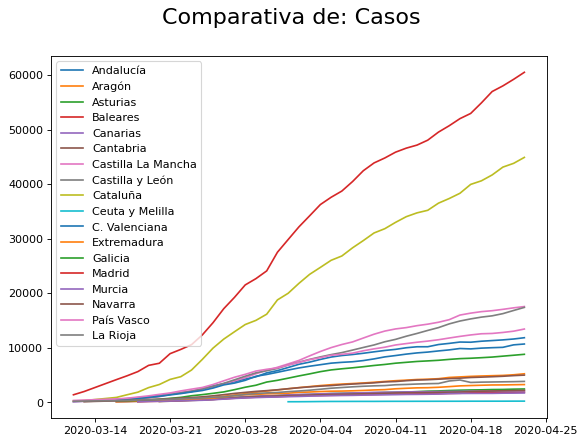

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


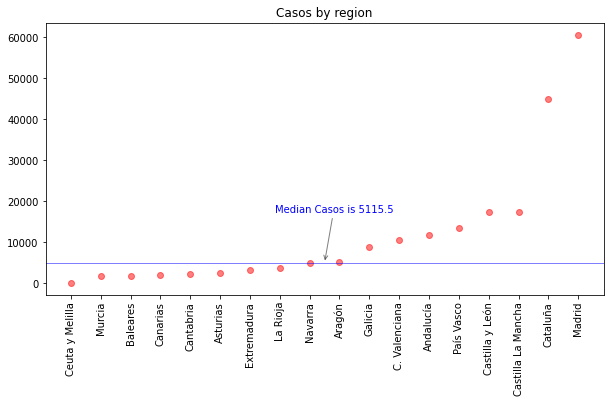

In [13]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

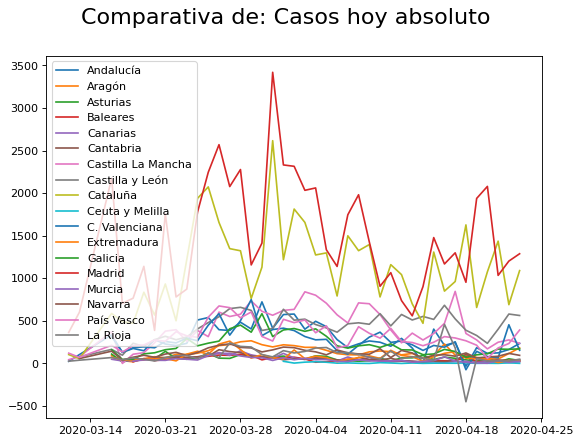

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,25,NaN,NaN,NaN,NaN,NaN,44,NaN,104,NaN,NaN,NaN,NaN,364,NaN,NaN,121,26
2020-03-13,104,NaN,NaN,NaN,NaN,NaN,79,77.0,56,NaN,NaN,NaN,NaN,602,NaN,57.0,71,38
2020-03-16,335,94.0,110.0,NaN,49.0,NaN,373,165.0,587,NaN,315.0,72.0,160.0,2175,NaN,144.0,213,69
2020-03-17,129,33.0,16.0,NaN,29.0,NaN,0,97.0,491,NaN,132.0,42.0,47.0,706,NaN,39.0,135,43
2020-03-18,176,19.0,49.0,20.0,33.0,NaN,108,237.0,472,NaN,185.0,41.0,49.0,766,25.0,73.0,208,64
2020-03-19,149,55.0,50.0,57.0,39.0,NaN,126,200.0,836,NaN,195.0,47.0,112.0,1140,45.0,96.0,217,49
2020-03-20,279,79.0,52.0,34.0,67.0,61.0,243,279.0,568,NaN,184.0,56.0,125.0,388,37.0,72.0,275,29
2020-03-21,228,64.0,142.0,43.0,61.0,71.0,379,319.0,933,NaN,258.0,57.0,161.0,1756,36.0,110.0,260,67
2020-03-22,210,108.0,59.0,85.0,66.0,67.0,396,278.0,501,NaN,241.0,30.0,176.0,781,56.0,130.0,372,90


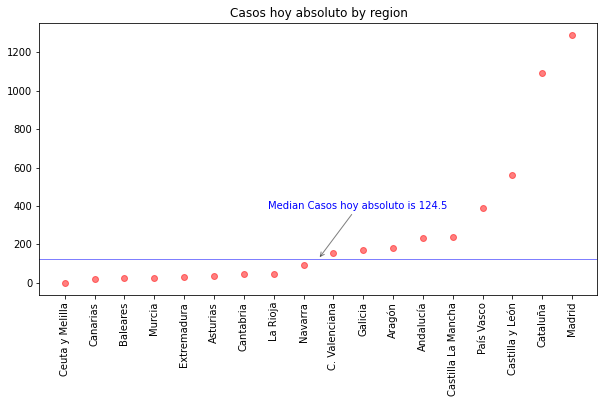

In [14]:
Insertar_Enlace("Comunidades_Casos_Hoy")

Report_Location("Casos hoy absoluto")

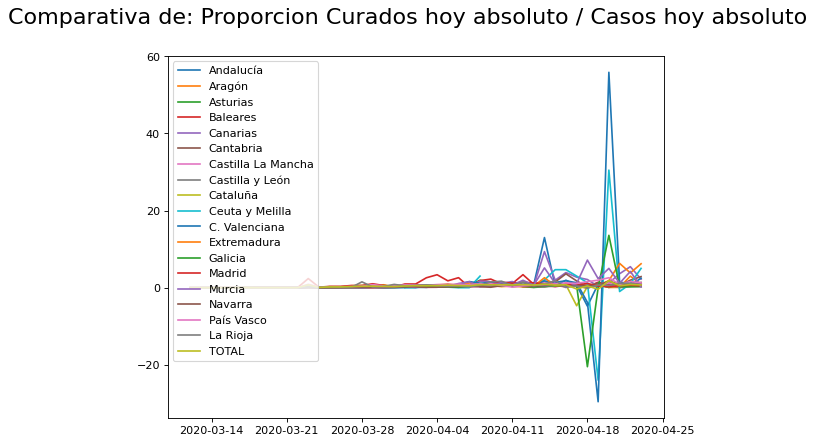

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
2020-03-16,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
2020-03-17,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
2020-03-18,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-19,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


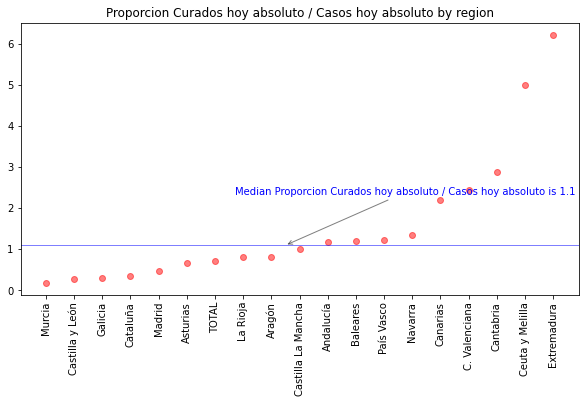

In [15]:
Insertar_Enlace("Comunidades_Curados_Casos_Hoy")

Report_Location("Proporcion Curados hoy absoluto / Casos hoy absoluto",True)

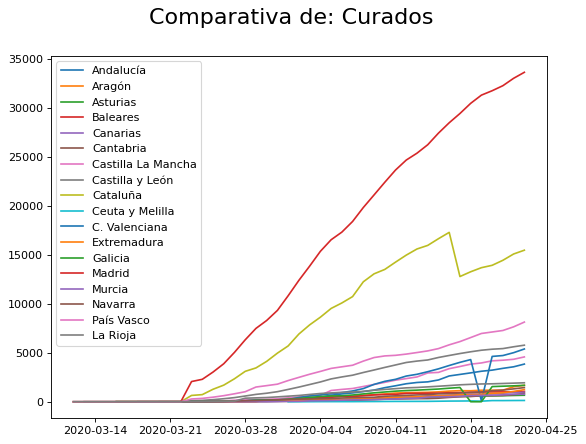

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


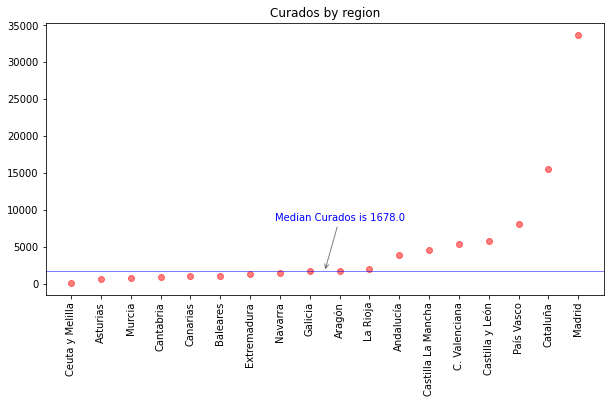

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
2020-03-19,766,169.0,164.75,34.00
2020-03-20,1002,236.0,173.50,8.75
2020-03-21,1326,324.0,209.00,35.50
2020-03-22,1720,394.0,280.75,71.75


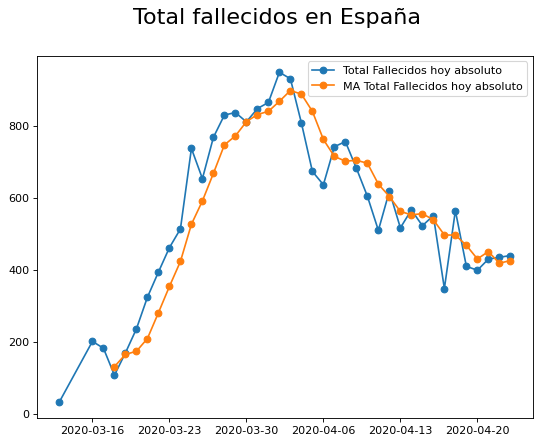

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    #df['MA variation']=  df['MA'] - df['MA'].shift(1)
    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



In [38]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        
        #print('df_forecast',df_forecast)
        
        #df_forecast = df_forecast.drop(df_forecast[df_forecast['ds'] > fecha].index)

        #df_forecast = df_forecast[df_forecast["trend"] >= 0]
        #df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0

        suma = df_forecast.yhat.sum()
        #print(fecha_short,suma)

            
        df_forecast[fecha_short] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',fecha_short]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(60)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Gráfico de comparativa de predicciones " + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,124.626667,9.607160,184.291410,124.626667,124.626667,-31.285049,-31.285049,-31.285049,-31.285049,-31.285049,-31.285049,0.0,0.0,0.0,93.341618
2,2020-03-17,176.628303,95.056853,265.670022,176.628303,176.628303,3.528676,3.528676,3.528676,3.528676,3.528676,3.528676,0.0,0.0,0.0,180.156979
3,2020-03-18,228.629939,161.195951,336.353265,228.629939,228.629939,23.924343,23.924343,23.924343,23.924343,23.924343,23.924343,0.0,0.0,0.0,252.554281
4,2020-03-19,280.631574,219.775699,388.926857,280.631574,280.631574,24.321474,24.321474,24.321474,24.321474,24.321474,24.321474,0.0,0.0,0.0,304.953048
5,2020-03-20,332.633213,238.134150,414.610977,332.633213,332.633213,-2.815319,-2.815319,-2.815319,-2.815319,-2.815319,-2.815319,0.0,0.0,0.0,329.817893
6,2020-03-21,384.634851,298.573901,473.355534,384.634851,384.634851,5.556497,5.556497,5.556497,5.556497,5.556497,5.556497,0.0,0.0,0.0,390.191348
7,2020-03-22,436.636490,325.068877,501.831013,436.636490,436.636490,-23.230621,-23.230621,-23.230621,-23.230621,-23.230621,-23.230621,0.0,0.0,0.0,413.405869
8,2020-03-23,488.638128,369.622568,543.956478,488.638128,488.638128,-31.285049,-31.285049,-31.285049,-31.285049,-31.285049,-31.285049,0.0,0.0,0.0,457.353079
9,2020-03-24,540.639766,462.901254,628.479285,540.639766,540.639766,3.528676,3.528676,3.528676,3.528676,3.528676,3.528676,0.0,0.0,0.0,544.168443
10,2020-03-25,592.641405,528.642409,700.999059,592.641405,592.641405,23.924343,23.924343,23.924343,23.924343,23.924343,23.924343,0.0,0.0,0.0,616.565748


Prediccion total para Total Fallecidos hoy absoluto : 25109.246134576795


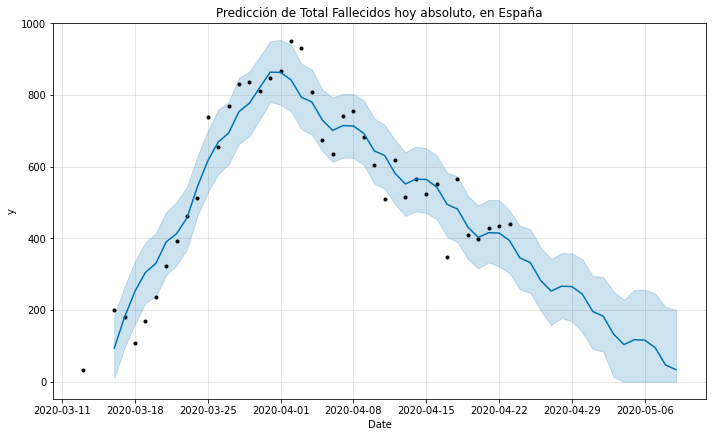

In [19]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df=df.rename(columns = {'Fecha':'ds', dimension : 'y' })
    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
2020-04-23      25132.476755
2020-04-22      24672.105241
2020-04-21      24507.771026
2020-04-20      24110.441951
datos reales    22083.000000
dtype: float64


,2020-04-23,2020-04-22,2020-04-21,2020-04-20,datos reales
ds,,,,,
2020-03-13,0.000000,0.000000,0.000000,0.000000,33.0
2020-03-16,93.341618,96.557685,95.646442,101.557340,201.0
2020-03-17,180.156979,183.409763,184.651652,180.407591,182.0
2020-03-18,252.554281,250.935414,247.111405,243.601870,107.0
2020-03-19,304.953048,292.724883,295.204190,292.905071,169.0
2020-03-20,329.817893,329.171631,330.114663,330.210047,236.0
2020-03-21,390.191348,389.506756,391.390538,391.528510,324.0
2020-03-22,413.405869,413.899901,415.490532,422.089360,394.0
2020-03-23,457.353079,466.011080,459.861122,471.741889,462.0


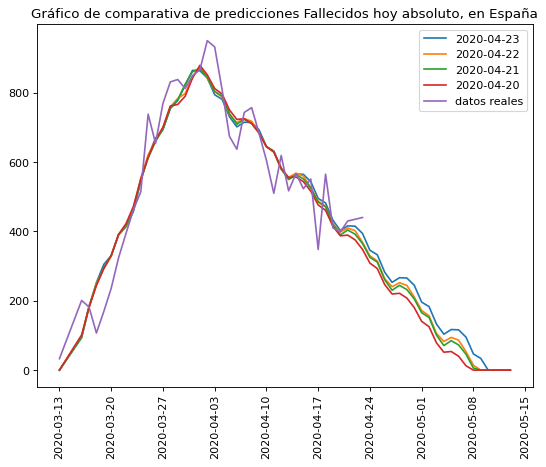

In [39]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


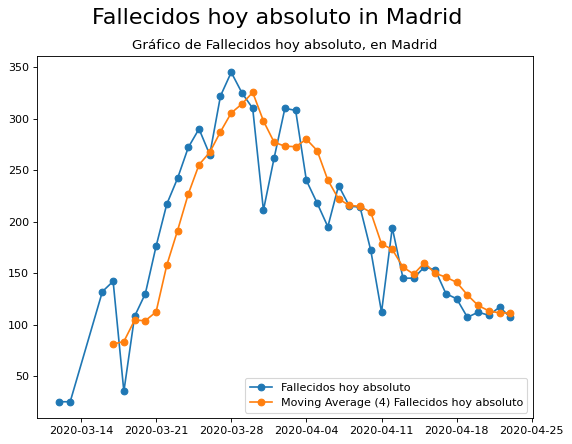

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,-1.405000,0.000000,42.729815,-1.405000,-1.405000,3.498468,3.498468,3.498468,3.498468,3.498468,3.498468,0.0,0.0,0.0,2.093469
2,2020-03-10,14.280485,0.000000,58.672650,14.280485,14.280485,-0.862808,-0.862808,-0.862808,-0.862808,-0.862808,-0.862808,0.0,0.0,0.0,13.417677
3,2020-03-11,29.965969,0.000000,65.521836,29.965969,29.965969,-9.081021,-9.081021,-9.081021,-9.081021,-9.081021,-9.081021,0.0,0.0,0.0,20.884948
4,2020-03-12,45.651453,7.671071,89.346600,45.651453,45.651453,2.558068,2.558068,2.558068,2.558068,2.558068,2.558068,0.0,0.0,0.0,48.209522
5,2020-03-13,61.336938,24.381669,110.798294,61.336938,61.336938,5.806252,5.806252,5.806252,5.806252,5.806252,5.806252,0.0,0.0,0.0,67.143190
6,2020-03-16,108.393391,68.212233,156.868880,108.393391,108.393391,3.498468,3.498468,3.498468,3.498468,3.498468,3.498468,0.0,0.0,0.0,111.891859
7,2020-03-17,124.078875,80.377490,163.352090,124.078875,124.078875,-0.862808,-0.862808,-0.862808,-0.862808,-0.862808,-0.862808,0.0,0.0,0.0,123.216067
8,2020-03-18,139.764359,90.430457,173.832226,139.764359,139.764359,-9.081021,-9.081021,-9.081021,-9.081021,-9.081021,-9.081021,0.0,0.0,0.0,130.683338
9,2020-03-19,155.449844,118.268268,199.723943,155.449844,155.449844,2.558068,2.558068,2.558068,2.558068,2.558068,2.558068,0.0,0.0,0.0,158.007912
10,2020-03-20,171.135328,135.436525,214.102853,171.135328,171.135328,5.806252,5.806252,5.806252,5.806252,5.806252,5.806252,0.0,0.0,0.0,176.941580


Prediccion total para Fallecidos hoy absoluto : 8215.134447721597


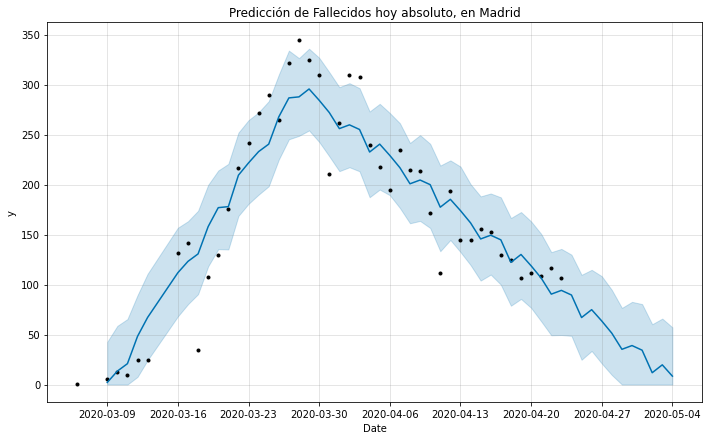

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
2020-04-23      8220.551876
2020-04-22      8171.373376
2020-04-21      8066.063610
2020-04-20      8031.848729
datos reales    7683.000000
dtype: float64


,2020-04-23,2020-04-22,2020-04-21,2020-04-20,datos reales
ds,,,,,
2020-03-06,0.000000,0.000000,0.000000,0.000000,1.0
2020-03-09,2.093469,1.746656,2.091574,2.299032,6.0
2020-03-10,13.417677,13.203096,13.745049,12.542354,13.0
2020-03-11,20.884948,20.802571,16.195507,16.327613,10.0
2020-03-12,48.209522,45.802361,46.101468,46.281274,25.0
2020-03-13,67.143190,67.093245,67.598184,67.819328,25.0
2020-03-16,111.891859,112.203777,113.252009,113.620743,132.0
2020-03-17,123.216067,123.660217,124.905484,123.864066,142.0
2020-03-18,130.683338,131.259692,127.355942,127.649325,35.0


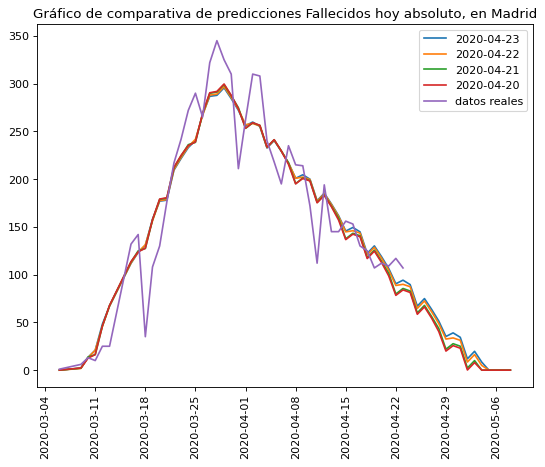

In [40]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


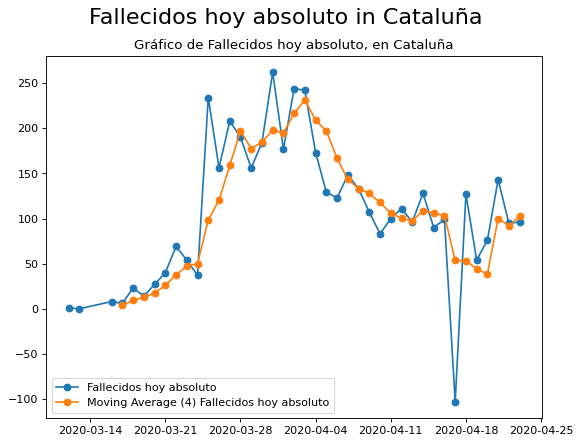

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-03-12,6.876157,0.000000,58.894930,6.876157,6.876157,1.933399,1.933399,1.933399,1.933399,1.933399,1.933399,0.0,0.0,0.0,8.809555
3,2020-03-16,40.807053,0.000000,75.701470,40.807053,40.807053,-16.275534,-16.275534,-16.275534,-16.275534,-16.275534,-16.275534,0.0,0.0,0.0,24.531519
4,2020-03-17,49.289776,6.751650,114.543623,49.289776,49.289776,7.569734,7.569734,7.569734,7.569734,7.569734,7.569734,0.0,0.0,0.0,56.859511
5,2020-03-18,57.772500,10.539128,123.268818,57.772500,57.772500,10.048031,10.048031,10.048031,10.048031,10.048031,10.048031,0.0,0.0,0.0,67.820531
6,2020-03-19,66.255224,11.449047,125.929749,66.255224,66.255224,1.933399,1.933399,1.933399,1.933399,1.933399,1.933399,0.0,0.0,0.0,68.188623
7,2020-03-20,74.737948,37.595131,151.939662,74.737948,74.737948,15.663091,15.663091,15.663091,15.663091,15.663091,15.663091,0.0,0.0,0.0,90.401039
8,2020-03-21,83.220672,28.232845,140.865337,83.220672,83.220672,2.421786,2.421786,2.421786,2.421786,2.421786,2.421786,0.0,0.0,0.0,85.642458
9,2020-03-22,91.703396,14.824209,121.992911,91.703396,91.703396,-21.360507,-21.360507,-21.360507,-21.360507,-21.360507,-21.360507,0.0,0.0,0.0,70.342890
10,2020-03-23,100.186120,27.804988,137.581841,100.186120,100.186120,-16.275534,-16.275534,-16.275534,-16.275534,-16.275534,-16.275534,0.0,0.0,0.0,83.910586
11,2020-03-24,108.668537,68.877674,174.882714,108.668537,108.668537,7.569734,7.569734,7.569734,7.569734,7.569734,7.569734,0.0,0.0,0.0,116.238271


Prediccion total para Fallecidos hoy absoluto : 5890.033046005952


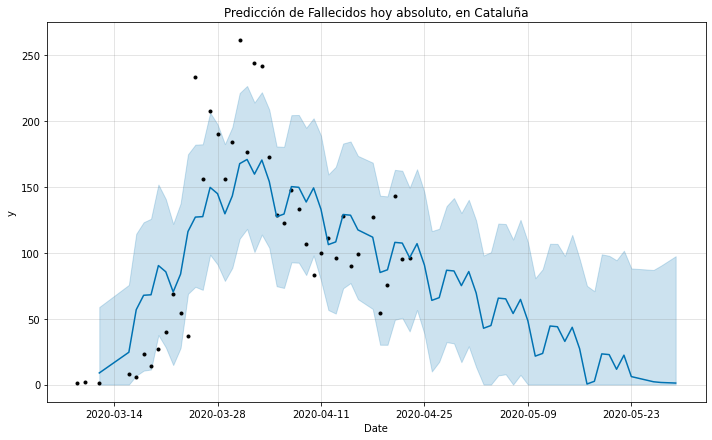

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


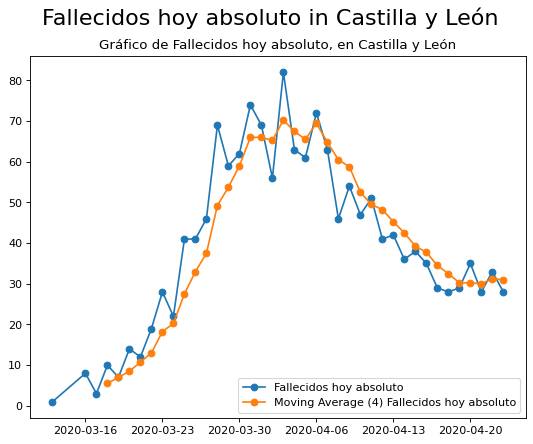

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,1.719415,0.000000,13.722945,1.719415,1.719415,3.502173,3.502173,3.502173,3.502173,3.502173,3.502173,0.0,0.0,0.0,5.221588
2,2020-03-17,5.850671,0.000000,13.491488,5.850671,5.850671,-1.038410,-1.038410,-1.038410,-1.038410,-1.038410,-1.038410,0.0,0.0,0.0,4.812261
3,2020-03-18,9.981927,2.048994,19.338752,9.981927,9.981927,0.359100,0.359100,0.359100,0.359100,0.359100,0.359100,0.0,0.0,0.0,10.341027
4,2020-03-19,14.113183,2.252070,19.924385,14.113183,14.113183,-2.743120,-2.743120,-2.743120,-2.743120,-2.743120,-2.743120,0.0,0.0,0.0,11.370063
5,2020-03-20,18.244439,11.408399,28.266817,18.244439,18.244439,1.958695,1.958695,1.958695,1.958695,1.958695,1.958695,0.0,0.0,0.0,20.203134
6,2020-03-21,22.375695,13.898073,31.427249,22.375695,22.375695,0.592351,0.592351,0.592351,0.592351,0.592351,0.592351,0.0,0.0,0.0,22.968046
7,2020-03-22,26.506952,15.778930,32.288577,26.506952,26.506952,-2.630790,-2.630790,-2.630790,-2.630790,-2.630790,-2.630790,0.0,0.0,0.0,23.876162
8,2020-03-23,30.638210,25.638253,43.201882,30.638210,30.638210,3.502173,3.502173,3.502173,3.502173,3.502173,3.502173,0.0,0.0,0.0,34.140383
9,2020-03-24,34.769468,25.146525,42.076178,34.769468,34.769468,-1.038410,-1.038410,-1.038410,-1.038410,-1.038410,-1.038410,0.0,0.0,0.0,33.731058
10,2020-03-25,38.900727,30.098022,47.660782,38.900727,38.900727,0.359100,0.359100,0.359100,0.359100,0.359100,0.359100,0.0,0.0,0.0,39.259826


Prediccion total para Fallecidos hoy absoluto : 1721.5728178242553


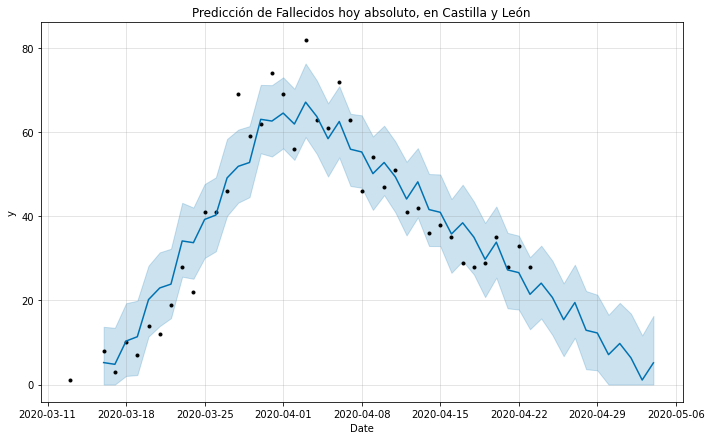

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


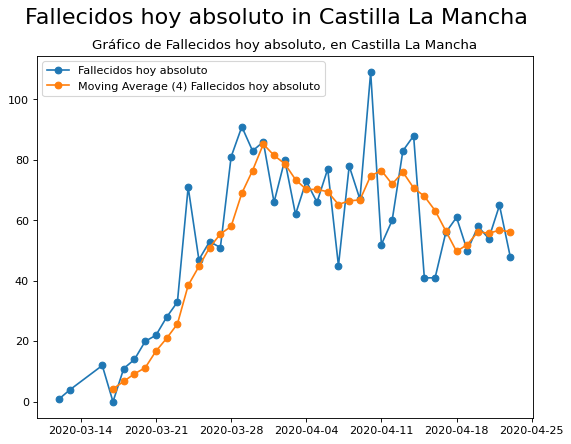

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,4.101294,0.000000,23.570117,4.101294,4.101294,1.564817,1.564817,1.564817,1.564817,1.564817,1.564817,0.0,0.0,0.0,5.666111
2,2020-03-16,15.838383,2.222016,37.713861,15.838383,15.838383,3.839165,3.839165,3.839165,3.839165,3.839165,3.839165,0.0,0.0,0.0,19.677548
3,2020-03-18,23.663110,2.328764,36.552962,23.663110,23.663110,-4.607922,-4.607922,-4.607922,-4.607922,-4.607922,-4.607922,0.0,0.0,0.0,19.055188
4,2020-03-19,27.575473,5.449314,39.023570,27.575473,27.575473,-5.358470,-5.358470,-5.358470,-5.358470,-5.358470,-5.358470,0.0,0.0,0.0,22.217003
5,2020-03-20,31.487836,15.694374,49.477724,31.487836,31.487836,1.564817,1.564817,1.564817,1.564817,1.564817,1.564817,0.0,0.0,0.0,33.052653
6,2020-03-21,35.400199,16.312907,52.493650,35.400199,35.400199,-1.142918,-1.142918,-1.142918,-1.142918,-1.142918,-1.142918,0.0,0.0,0.0,34.257282
7,2020-03-22,39.312563,20.374147,54.998344,39.312563,39.312563,-1.184000,-1.184000,-1.184000,-1.184000,-1.184000,-1.184000,0.0,0.0,0.0,38.128563
8,2020-03-23,43.224926,29.865189,64.080326,43.224926,43.224926,3.839165,3.839165,3.839165,3.839165,3.839165,3.839165,0.0,0.0,0.0,47.064090
9,2020-03-24,47.137289,37.192548,72.516418,47.137289,47.137289,6.889328,6.889328,6.889328,6.889328,6.889328,6.889328,0.0,0.0,0.0,54.026617
10,2020-03-25,51.049652,28.794936,64.673258,51.049652,51.049652,-4.607922,-4.607922,-4.607922,-4.607922,-4.607922,-4.607922,0.0,0.0,0.0,46.441730


Prediccion total para Fallecidos hoy absoluto : 4294.288255782187


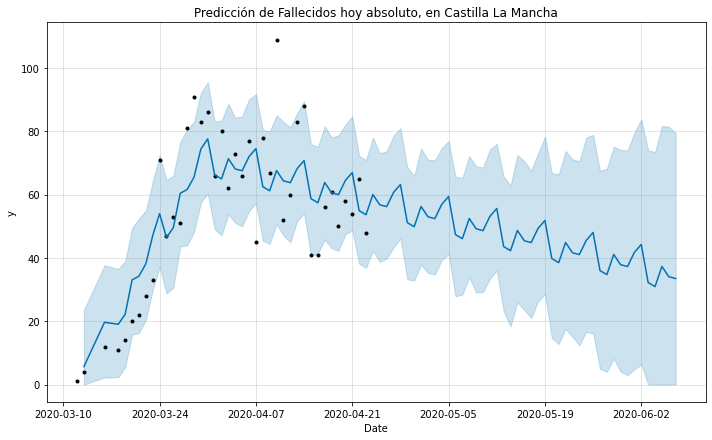

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

,Hospitalizados,Moving Average (4) Hospitalizados
Fecha,,
2020-03-12,0,NaN
2020-03-13,0,NaN
2020-03-16,0,NaN
2020-03-17,0,0.00
2020-03-18,0,0.00
2020-03-19,0,0.00
2020-03-20,0,0.00
2020-03-21,7388,1847.00
2020-03-22,8441,3957.25


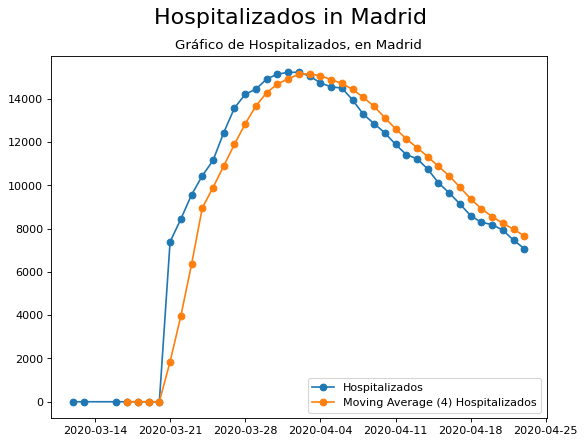

In [31]:
dimension = 'Hospitalizados'
report_single_location_single_dimension('Madrid',dimension)

Insertar_Enlace("Reporte_Hospitalizados_Madrid")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,7631.695189,7381.658017,7394.640420,7631.695189,7631.695189,-243.308712,-243.308712,-243.308712,-243.308712,-243.308712,-243.308712,0.0,0.0,0.0,7388.386477
1,2020-03-22,8618.884362,8434.145692,8447.444706,8618.884362,8618.884362,-178.270973,-178.270973,-178.270973,-178.270973,-178.270973,-178.270973,0.0,0.0,0.0,8440.613389
2,2020-03-23,9464.658931,9553.816793,9566.857309,9464.658931,9464.658931,95.578112,95.578112,95.578112,95.578112,95.578112,95.578112,0.0,0.0,0.0,9560.237043
3,2020-03-24,10250.972867,10437.387847,10450.456323,10250.972867,10250.972867,192.790260,192.790260,192.790260,192.790260,192.790260,192.790260,0.0,0.0,0.0,10443.763127
4,2020-03-25,11056.552505,11147.008394,11159.828973,11056.552505,11056.552505,97.210367,97.210367,97.210367,97.210367,97.210367,97.210367,0.0,0.0,0.0,11153.762871
5,2020-03-26,12361.658768,12432.478087,12445.761446,12361.658768,12361.658768,77.578492,77.578492,77.578492,77.578492,77.578492,77.578492,0.0,0.0,0.0,12439.237260
6,2020-03-27,13621.577212,13573.703641,13586.671419,13621.577212,13621.577212,-41.577546,-41.577546,-41.577546,-41.577546,-41.577546,-41.577546,0.0,0.0,0.0,13579.999666
7,2020-03-28,14453.545656,14203.455525,14216.363300,14453.545656,14453.545656,-243.308712,-243.308712,-243.308712,-243.308712,-243.308712,-243.308712,0.0,0.0,0.0,14210.236944
8,2020-03-29,14633.797322,14449.274396,14462.307628,14633.797322,14633.797322,-178.270973,-178.270973,-178.270973,-178.270973,-178.270973,-178.270973,0.0,0.0,0.0,14455.526349
9,2020-03-30,14819.895799,14908.922432,14922.307856,14819.895799,14819.895799,95.578112,95.578112,95.578112,95.578112,95.578112,95.578112,0.0,0.0,0.0,14915.473911


Prediccion total para Hospitalizados : 458619.9069966422


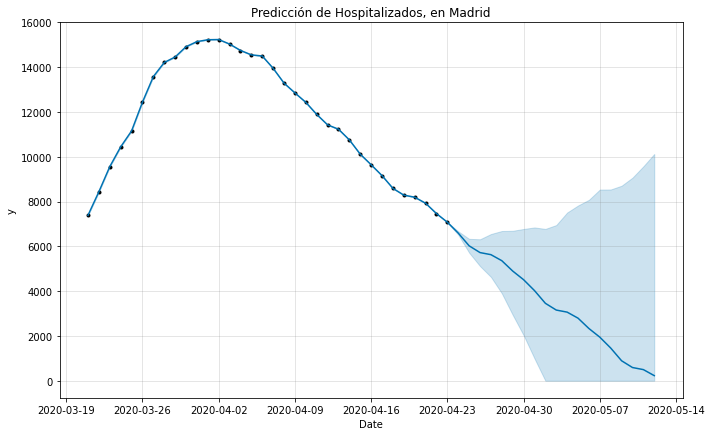

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


Las predicciones del total de Hospitalizados en Madrid, cambian dia a dia
2020-04-23      458486.695684
2020-04-22      455171.000000
2020-04-21      448958.000000
2020-04-20      441603.000000
datos reales    395313.000000
dtype: float64


,2020-04-23,2020-04-22,2020-04-21,2020-04-20,datos reales
ds,,,,,
2020-03-21,7388.386477,7388.0,7388.0,7388.0,7388.0
2020-03-22,8440.613389,8441.0,8441.0,8441.0,8441.0
2020-03-23,9560.237043,9561.0,9561.0,9561.0,9561.0
2020-03-24,10443.763127,10443.0,10443.0,10443.0,10443.0
2020-03-25,11153.762871,11153.0,11153.0,11153.0,11153.0
2020-03-26,12439.237260,12440.0,12440.0,12440.0,12440.0
2020-03-27,13579.999666,13580.0,13580.0,13580.0,13580.0
2020-03-28,14210.236944,14211.0,14211.0,14211.0,14211.0
2020-03-29,14455.526349,14454.0,14454.0,14454.0,14454.0


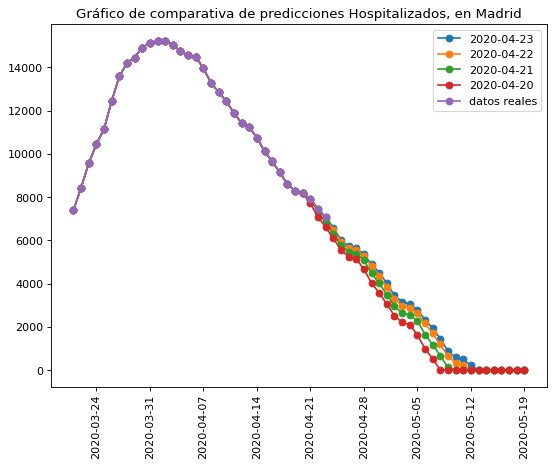

In [33]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Hospitalizados_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


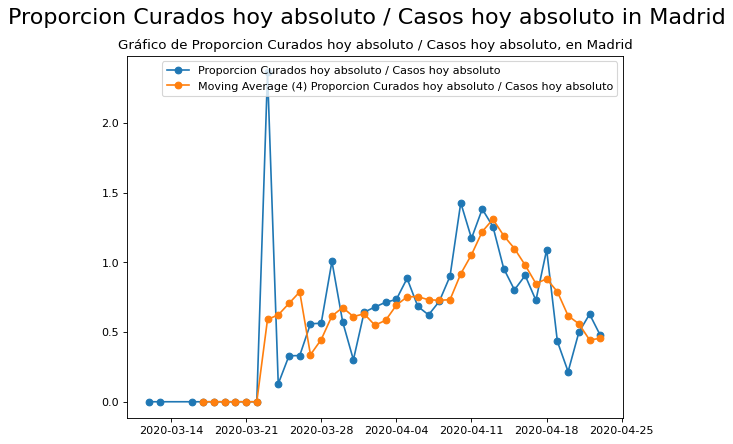

In [34]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [35]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [36]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

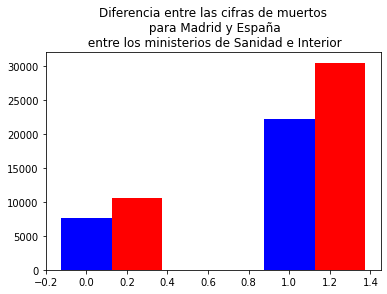

In [37]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
